# Import modules

In [17]:
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler



# from geopy.distance import great_circle
# from shapely.geometry import MultiPoint

# Import the pickle

In [2]:
df_arbres = pd.read_pickle('./data/arbres.pkl')

# Split the data frame into testing and training sets

In [3]:
df_train, df_test = train_test_split(df_arbres, test_size=0.25, random_state=42)

# Explore the training data further

In [4]:
# create copy of the training data set to explore
df_explore = df_train.copy()

In [5]:
df_explore.isna().sum()

sous_categorie             0
sous_categorie_desc        0
code_parent                0
code_parent_desc           0
adr_secteur                0
genre_bota                32
espece                   896
stadededeveloppement    1885
anneedeplantation          0
hauteurarbre            4302
latitude                   0
longitude                  0
dtype: int64

## Fill empty values

In [6]:
imp = SimpleImputer(strategy='most_frequent')
df_explore[df_explore.columns] = imp.fit_transform(df_explore[df_explore.columns])
df_explore.isna().sum()

sous_categorie          0
sous_categorie_desc     0
code_parent             0
code_parent_desc        0
adr_secteur             0
genre_bota              0
espece                  0
stadededeveloppement    0
anneedeplantation       0
hauteurarbre            0
latitude                0
longitude               0
dtype: int64

## Standardize the quantative data

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

col_num = df_arbres.select_dtypes(include=numerics).columns
col_cat = df_arbres.select_dtypes(exclude=numerics).columns[:-2]
col_geo = df_arbres.select_dtypes(exclude=numerics).columns[-2:]

# create a StandardScaler object
scaler = StandardScaler().set_output()

# fit and transform the data
df_explore[col_num] = scaler.fit_transform(df_explore[col_num])


## Encode the qualitative data

In [8]:
df_explore[col_cat].nunique().sort_values(ascending=False)

code_parent_desc        1444
code_parent             1444
espece                   273
genre_bota               113
sous_categorie             4
sous_categorie_desc        4
stadededeveloppement       3
hauteurarbre               3
dtype: int64

In [15]:
le = LabelEncoder()
for col in col_cat:
    df_explore[col] = le.fit_transform(df_explore[col])

In [16]:
df_explore.head()

,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,adr_secteur,genre_bota,espece,stadededeveloppement,anneedeplantation,hauteurarbre,latitude,longitude
3406,2,1,955,1353,-0.080196,68,95,1,-0.794787,0,45.1639055251646,5.727471239050052
6046,0,0,920,453,-0.080847,9,263,0,-0.519983,2,45.174690219477796,5.740280662246903
24971,0,0,116,470,-0.080196,108,247,0,-0.574944,2,45.16413218624576,5.738749652064754
19120,2,1,1178,534,-0.080196,43,80,0,-0.849747,2,45.164290397633465,5.733986222792636
8962,2,1,598,652,-0.081824,9,260,0,0.304429,0,45.1830253353635,5.713802198924274


## Encode the geo data

In [37]:
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(df_explore[col_geo].astype('float').values))
clusters = pd.DataFrame(db.fit_predict(np.radians(df_explore[col_geo].astype('float').values)))

df_explore['geo'] = clusters

<Axes: xlabel='longitude', ylabel='latitude'>

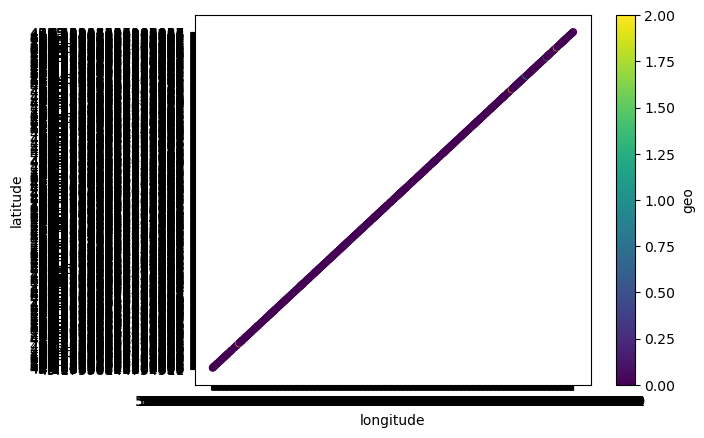

In [38]:
df_explore.sample(1000).plot(kind='scatter', x='longitude', y='latitude', c='geo')

In [40]:
df_explore.geo.unique()

array([ 0., nan,  2.,  1.])

In [42]:
df_explore[col_geo].astype('float').isna().sum()

latitude     0
longitude    0
dtype: int64

In [11]:
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
test = enc.fit(df_explore[col_num])

# Create an encoder 
encoder= OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
 
# Train encoder using multiple columns
encoder.fit(df_explore[col_num]) 
 
# Get encoded column names 
encoded_columns=encoder.get_feature_names_out() 
 
# Transform data using the trained encoder 
encoded_data = encoder.transform(df_explore[col_num]) 
 
# Create a dataframe using the encoded data 
encoded_df=pd.DataFrame(encoded_data, columns=encoded_columns) 
encoded_df

,adr_secteur_-0.08182354126589092,adr_secteur_-0.0814979931583435,adr_secteur_-0.08117244505079606,adr_secteur_-0.08084689694324863,adr_secteur_-0.0805213488357012,adr_secteur_-0.08019580072815376,adr_secteur_12.337836761668687,adr_secteur_12.34011559842152,adr_secteur_12.369740476208335,adr_secteur_12.38927336266118,...,anneedeplantation_1.2387614318825555,anneedeplantation_1.2937221878524678,anneedeplantation_1.3486829438223804,anneedeplantation_1.4036436997922928,anneedeplantation_1.4586044557622053,anneedeplantation_1.5135652117321177,anneedeplantation_1.5685259677020302,anneedeplantation_1.6234867236719426,anneedeplantation_1.7334082356117675,anneedeplantation_1.78836899158168
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22140,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22141,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22142,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
